# Analysis LEAP3 FA z-scores: extreme deviations, t-test and u-test

### Globals

In [8]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
import statsmodels 
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection

### Load data

In [17]:
# The source directory
data_dir = '/home/preclineu/ramcir/Desktop/Clinical/data/'

# The IDP file
idp_list = 'phenotypes_fa.txt'

# Read the IDPs list and store the names
with open(os.path.join(data_dir, idp_list)) as f:
    idp_ids = f.read().splitlines()

# Where the models live
model_dir = os.path.join(data_dir,'Models','LEAP3')

# Loading the data for analysis
df_leap3 = pd.read_pickle(os.path.join(data_dir, 'leap3_df_te.pkl'))

# Reset df_te index to match with z_scores list later
df_leap3 = df_leap3.reset_index().rename(columns={'index': 'id'})

z_scores_list = []  # to store z_scores 

for idp in idp_ids:
    # Define path to z-scores
    z_path_test = os.path.join(model_dir, idp, 'Z_leap3.txt')
    
    # Read z-scores and append
    z_scores = pd.read_csv(z_path_test, header=None, names=[f'Zscore_{idp}'])
    z_scores = z_scores.reset_index(drop=True)
    z_scores_list.append(z_scores)

# Concatenate z-scores with the rest of the data
data_with_z_scores = pd.concat([df_leap3] + z_scores_list, axis=1)

# Save 
data_with_z_scores.to_pickle("/home/preclineu/ramcir/Desktop/Clinical/data/leap3_data_zscores.pkl")

### Calculate z-score deviations

A Z-score threshold of ±2.6 is statistically important because it corresponds to the extreme 1% of a standard  
normal distribution (specifically, the top and bottom 0.5% of values)

In [10]:
zscore_columns = [col for col in data_with_z_scores.columns if col.startswith('Zscore_FA')]

# Initialize the result dictionary
results = {
    'Column': [],
    '% of patients z above th': [],
    '% of controls z above th': [],
    '% of patients z below th': [],
    '% of controls z below th': []
}

# Process each Zscore column
for col in zscore_columns:
    # Filter participants with diagnosis 
    patients = data_with_z_scores[data_with_z_scores['t1_diagnosis'] == 2]
    controls = data_with_z_scores[data_with_z_scores['t1_diagnosis'] == 1]

    # Calculate percentage of patients with Z-score > threshold
    th = 2.6
    patients_above_threshold = (patients[col] > th).mean() * 100
    patients_below_threshold = (patients[col] < -th).mean() * 100

    # Calculate percentage of controls with Z-score > threshold
    controls_above_threshold = (controls[col] > th).mean() * 100
    controls_below_threshold = (controls[col] < -th).mean() * 100

    # Append results to the dictionary
    results['Column'].append(col)
    results['% of patients z above th'].append(patients_above_threshold)
    results['% of controls z above th'].append(controls_above_threshold)
    results['% of patients z below th'].append(patients_below_threshold)
    results['% of controls z below th'].append(controls_below_threshold)

# Convert results to a dataframe
results_df = pd.DataFrame(results)

# Display the result dataframe
# results_df

### Plot results of the z-score deviations

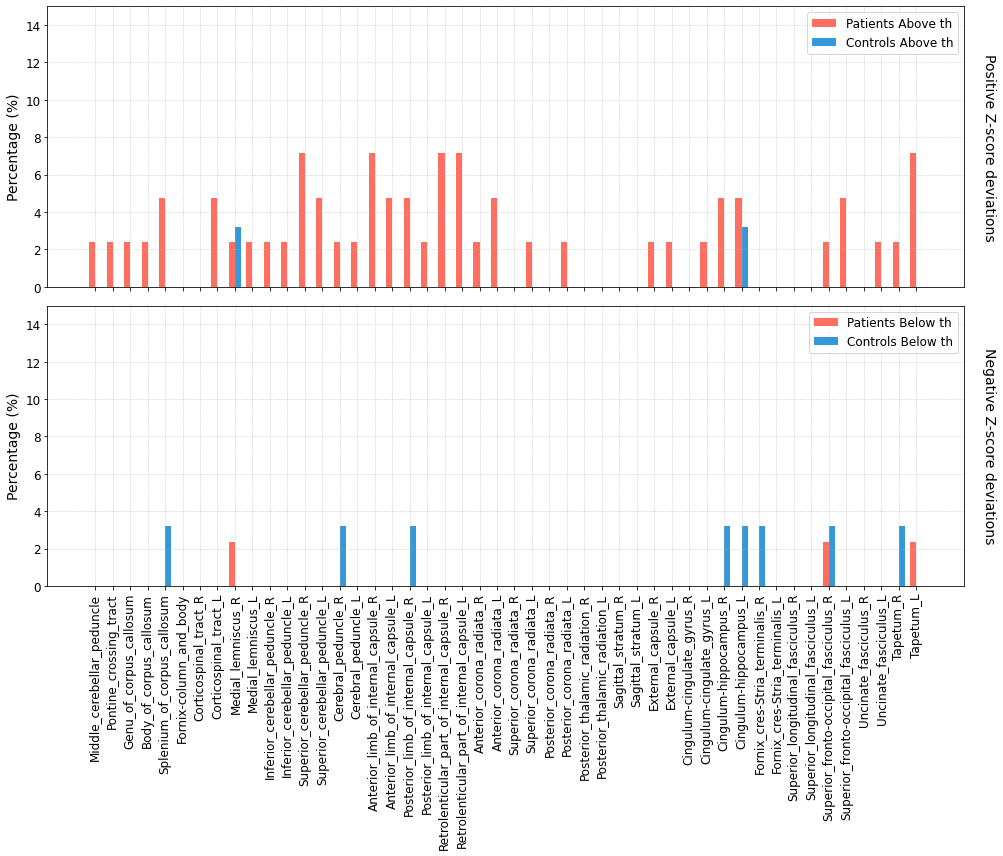

In [11]:
# Define updated colours
color_red = '#ff6f61'  
color_blue = '#3498db'  

# Remove unnecessary prefixes from the column names for clearer x-axis labels
results_df['Column'] = results_df['Column'].str.replace('Zscore_FA_mean_of_', '', regex=False)

# Set the figure size
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)  # Share x-axis for better alignment
bar_width = 0.35
index = range(len(results_df))

# Plot 1: Positive Z-score deviations
axes[0].bar(index, results_df['% of patients z above th'], bar_width, label='Patients Above th', color=color_red)
axes[0].bar([i + bar_width for i in index], results_df['% of controls z above th'], bar_width, label='Controls Above th', color=color_blue)

# Formatting for the top plot
axes[0].set_ylabel('Percentage (%)', fontsize=14)
axes[0].yaxis.set_tick_params(labelsize=12)
axes[0].set_ylim(0, 15)
axes[0].legend(fontsize=12)
axes[0].text(1.02, 0.5, 'Positive Z-score deviations', fontsize=14, rotation=270, transform=axes[0].transAxes, va='center')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid

# Plot 2: Negative Z-score deviations
axes[1].bar(index, results_df['% of patients z below th'], bar_width, label='Patients Below th', color=color_red)
axes[1].bar([i + bar_width for i in index], results_df['% of controls z below th'], bar_width, label='Controls Below th', color=color_blue)

# Formatting for the bottom plot
axes[1].set_ylabel('Percentage (%)', fontsize=14)
axes[1].set_ylim(0, 15)
axes[1].set_xticks([i + bar_width / 2 for i in index])  # Align x-ticks
axes[1].set_xticklabels(results_df['Column'], rotation=90, fontsize=12)  # Add cleaned x-ticks here
axes[1].yaxis.set_tick_params(labelsize=12)
axes[1].legend(fontsize=12)
axes[1].text(1.02, 0.5, 'Negative Z-score deviations', fontsize=14, rotation=270, transform=axes[1].transAxes, va='center')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid

# Tight layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


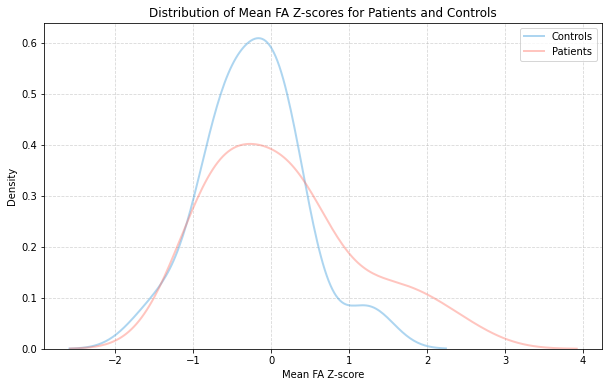

In [12]:
# Define colors
color_blue = '#3498db'
color_red = '#ff6f61'

# Compute the mean Z-score across all IDPs for each participant
data_with_z_scores['mean_Zscore_FA'] = data_with_z_scores[zscore_columns].mean(axis=1)

# Filter for patients and controls
patients = data_with_z_scores[data_with_z_scores['t1_diagnosis'] == 2]
controls = data_with_z_scores[data_with_z_scores['t1_diagnosis'] == 1]

# Plot KDE distributions of mean Z-scores
plt.figure(figsize=(10, 6))

sns.kdeplot(data=controls['mean_Zscore_FA'], color=color_blue, alpha=0.4, label='Controls', linewidth=2)
sns.kdeplot(data=patients['mean_Zscore_FA'], color=color_red, alpha=0.4, label='Patients', linewidth=2)

# Add labels and title
plt.xlabel("Mean FA Z-score")
plt.ylabel("Density")
plt.title("Distribution of Mean FA Z-scores for Patients and Controls")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()



### T test statistic


Nominally significant effects (p < 0.05):
Zscore_FA_mean_of_Genu_of_corpus_callosum
Zscore_FA_mean_of_Body_of_corpus_callosum
Zscore_FA_mean_of_Posterior_limb_of_internal_capsule_R
Zscore_FA_mean_of_Posterior_limb_of_internal_capsule_L
Zscore_FA_mean_of_Retrolenticular_part_of_internal_capsule_R
Zscore_FA_mean_of_Retrolenticular_part_of_internal_capsule_L
Zscore_FA_mean_of_Anterior_corona_radiata_R
Zscore_FA_mean_of_Anterior_corona_radiata_L
Zscore_FA_mean_of_Superior_corona_radiata_R
Zscore_FA_mean_of_Posterior_corona_radiata_R
Zscore_FA_mean_of_Posterior_corona_radiata_L
Zscore_FA_mean_of_Cingulum-cingulate_gyrus_R
Zscore_FA_mean_of_Cingulum-cingulate_gyrus_L
Zscore_FA_mean_of_Cingulum-hippocampus_R
Zscore_FA_mean_of_Superior_longitudinal_fasciculus_R
Zscore_FA_mean_of_Superior_longitudinal_fasciculus_L
Zscore_FA_mean_of_Superior_fronto-occipital_fasciculus_R
Zscore_FA_mean_of_Superior_fronto-occipital_fasciculus_L

FDR-corrected significant effects:



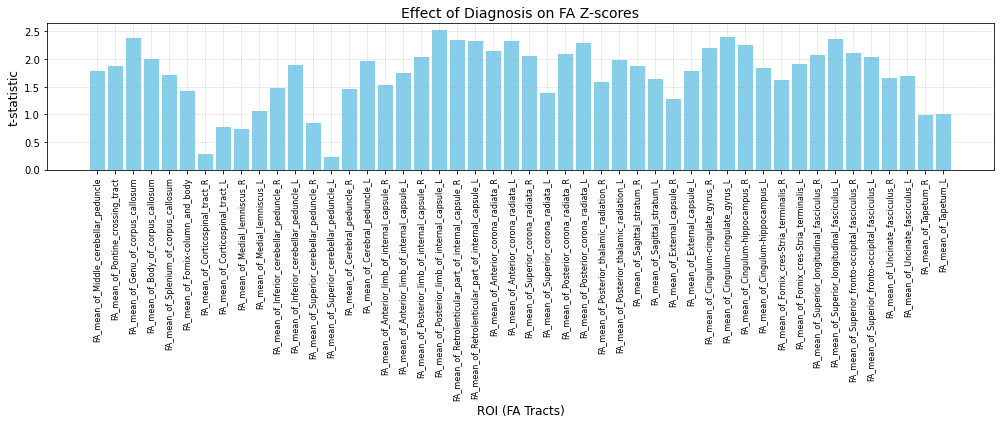

In [13]:
# Extract Z-score columns
zscore_columns = [col for col in data_with_z_scores.columns if col.startswith('Zscore_')]

# Define diagnosis masks
# Assuming 't1_diagnosis' == 1 for controls and 2 for patients
patients = data_with_z_scores['t1_diagnosis'] == 2
controls = data_with_z_scores['t1_diagnosis'] == 1

# Run t-tests for each Z-score column
t_stat_list = []
p_values_list = []

for col in zscore_columns:
    t_stat, p_value = stats.ttest_ind(
        data_with_z_scores.loc[patients, col].dropna(),  # Patients' Z-scores
        data_with_z_scores.loc[controls, col].dropna(),  # Controls' Z-scores
        equal_var=False  # Welch's t-test for unequal variance
    )
    t_stat_list.append(t_stat)
    p_values_list.append(p_value)

# Apply FDR correction
h, pfdr = fdrcorrection(p_values_list)

# Display results
print("\nNominally significant effects (p < 0.05):")
print("\n".join([zscore_columns[i] for i in np.where(np.array(p_values_list) < 0.05)[0]]))

print("\nFDR-corrected significant effects:")
print("\n".join([zscore_columns[i] for i in np.where(h)[0]]))

# Plot the t-statistics
plt.figure(figsize=(14, 6))
plt.bar(range(len(t_stat_list)), t_stat_list, color='skyblue')
plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel('ROI (FA Tracts)', fontsize=12)
plt.ylabel('t-statistic', fontsize=12)
plt.title('Effect of Diagnosis on FA Z-scores', fontsize=14)
plt.xticks(range(len(t_stat_list)), [col.replace('Zscore_', '') for col in zscore_columns], rotation=90, fontsize=8)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [14]:
data_with_z_scores['t1_diagnosis'].value_counts()

2    42
1    31
Name: t1_diagnosis, dtype: int64

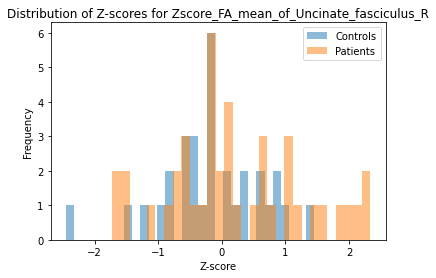

In [15]:
tract = 'Zscore_FA_mean_of_Uncinate_fasciculus_R'
plt.hist(data_with_z_scores[data_with_z_scores['t1_diagnosis'] == 1][tract], bins=30, alpha=0.5, label='Controls')
plt.hist(data_with_z_scores[data_with_z_scores['t1_diagnosis'] == 2][tract], bins=30, alpha=0.5, label='Patients')
plt.title(f'Distribution of Z-scores for {tract}')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Non-parametrics test (Mann-Whitney U test)

In [16]:
# Compute Z-score extremes
zscore_columns = [col for col in data_with_z_scores.columns if col.startswith('Zscore_FA')]

# Initialize results dictionary
results = {
    'column': [],
    '% of patients z above threshold': [],
    '% of controls z above threshold': [],
    '% of patients z below -threshold': [],
    '% of controls z below -threshold': []
}

# Set the threshold
threshold = 2.6

# Calculate percentages for Z-score extremes
for col in zscore_columns:
    patients = data_with_z_scores[data_with_z_scores['t1_diagnosis'] == 2]
    controls = data_with_z_scores[data_with_z_scores['t1_diagnosis'] == 1]

    patients_above_threshold = (patients[col] > threshold).mean() * 100
    patients_below_threshold = (patients[col] < -threshold).mean() * 100
    controls_above_threshold = (controls[col] > threshold).mean() * 100
    controls_below_threshold = (controls[col] < -threshold).mean() * 100

    results['column'].append(col)
    results['% of patients z above threshold'].append(patients_above_threshold)
    results['% of controls z above threshold'].append(controls_above_threshold)
    results['% of patients z below -threshold'].append(patients_below_threshold)
    results['% of controls z below -threshold'].append(controls_below_threshold)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Mann-Whitney U test
positive_deviations_patients = results_df['% of patients z above threshold']
positive_deviations_controls = results_df['% of controls z above threshold']
negative_deviations_patients = results_df['% of patients z below -threshold']
negative_deviations_controls = results_df['% of controls z below -threshold']

# Perform Mann-Whitney U tests
stat_positive, p_value_positive = mannwhitneyu(positive_deviations_patients, positive_deviations_controls)
stat_negative, p_value_negative = mannwhitneyu(negative_deviations_patients, negative_deviations_controls)

# Print results
print(f"Positive Deviations: U-statistic = {stat_positive}, p-value = {p_value_positive}")
print(f"Negative Deviations: U-statistic = {stat_negative}, p-value = {p_value_negative}")

# Collect p-values for corrections
p_values = [p_value_positive, p_value_negative]  # Extend this list if testing more ROIs

# Apply Bonferroni-Holm correction
reject, p_corrected, _, _ = multipletests(p_values, method='holm')

# Print corrected p-values
print(f"Corrected p-values: {p_corrected}")


Positive Deviations: U-statistic = 1914.0, p-value = 1.041518500189807e-10
Negative Deviations: U-statistic = 1020.0, p-value = 0.0811686855812059
Corrected p-values: [2.08303700e-10 8.11686856e-02]
